# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o. 

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Ensure you are running Python 3.10, 3.11 or 3.12 in a freshly created virtual environment.

In [1]:
import sys
assert sys.version_info >= (3, 10) and sys.version_info < (3, 13), "Use Python 3.10, 3.11, or 3.12 to run this notebook."

## Step 2: Install dependencies

In [2]:
%%capture
!pip install -q --progress-bar on "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    langchain_huggingface \
    langchain_milvus \
    docling

In [3]:
pip install PyPDF2

  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
Note: you may need to restart the kernel to use updated packages.


## Step 3: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

## Step 4: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [ ]:
# Uncomment to incorporate docling
# import os, types
# import pandas as pd
# from botocore.client import Config
# import ibm_boto3

# def __iter__(self): return 0

# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share the notebook.

# cos_client = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='oaFpQtysFBbVsVjUra2HFnFHZplTrp-xfsMACtAeM7rs',
#     ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

# bucket = 'telus-donotdelete-pr-nb036zw9ucerif'
# object_key = 'CSR-ACX7024-configuration-guide-v1.1.pdf'

# # load data of type "application/pdf" into a botocore.response.StreamingBody object.
# # Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# # ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# # pandas documentation: http://pandas.pydata.org/

# streaming_body_2 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']


INFO:numexpr.utils:Note: NumExpr detected 56 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


In [3]:
import PyPDF2
import io

# Local PDF path
local_pdf_path = "/Users/denizaskin/telus-incident-mgmt-copilot/notebooks/wxO_api/CSR-ACX7024-configuration-guide-v1.1.pdf"

# Open the PDF file in binary read mode
with open(local_pdf_path, "rb") as f:
    pdf_bytes = f.read()

# Wrap the bytes into a BytesIO object
pdf_file = io.BytesIO(pdf_bytes)

# Use PyPDF2 to read the PDF from memory
pdf_reader = PyPDF2.PdfReader(pdf_file)

# Extract text only from the first page
first_page_text = pdf_reader.pages[0].extract_text()

print(first_page_text)

   
Title:   Juniper ACX7024 CSR Configuration Guide for TELUS 
Mobility RAN Services 
(Best Common Practise) 
 
  
Abstract:   This document presents the technical description of software 
configuration on Juniper ACX7024 CSR and to be deployed on TELUS 
Mobility RAN IP backhaul project. 
  
  
Author 
Ricky Ip 
  
Last Revised Date 
January 11, 2024 
  
Issue 
1.1 
   
The information herein is TELUS Communications Inc. confidential and proprietary.  Any 
review, distribution or other use of this information outside of one’s scope of employment with 
TELUS is strictly prohibited.  TELUS Communications Inc. will avail itself of all legal rights and 
remedies in protecting the confidentiality, property rights, and use of the information.  If you 
are not a TELUS employee and have this information please call 1-877-333-8888 
immediately. 



In [ ]:
# Uncomment to incorporate docling
# import io
# from docling.document_converter import DocumentConverter, PdfFormatOption
# from docling.datamodel.base_models import InputFormat, DocumentStream
# from docling.datamodel.pipeline_options import PdfPipelineOptions


# streaming_body_1 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']
# pdf_bytes = streaming_body_1.read()


# document_stream = DocumentStream(
#     name="test-doc.pdf",  # required: provide a name ending with .pdf
#     stream=io.BytesIO(pdf_bytes),  # required: pass the PDF as a BytesIO stream
#     input_format=InputFormat.PDF
# )


# pdf_pipeline_options = PdfPipelineOptions(
#     do_ocr=False,
#     generate_picture_images=True,
# )
# format_options = {
#     InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
# }


# converter = DocumentConverter(format_options=format_options)


# converted_document = converter.convert(source=document_stream).document

# # Output the converted document
# #print(converted_document)


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash 33cd645429398fb816f544381a230d9c
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
INFO:docling.utils.accelerator_utils:Accelerator device: 'cpu'
INFO:docling.utils.a

In [12]:
import io
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat, DocumentStream
from docling.datamodel.pipeline_options import PdfPipelineOptions

# Load PDF from local path instead of COS
local_pdf_path = "/Users/denizaskin/telus-incident-mgmt-copilot/notebooks/wxO_api/CSR-ACX7024-configuration-guide-v1.1.pdf"
with open(local_pdf_path, "rb") as f:
    pdf_bytes = f.read()

# Wrap the bytes into a BytesIO stream
document_stream = DocumentStream(
    name="CSR-ACX7024-configuration-guide-v1.1.pdf",  # required: filename with .pdf extension
    stream=io.BytesIO(pdf_bytes),  # required: pass the PDF as a BytesIO stream
    input_format=InputFormat.PDF
)

# Set PDF pipeline options
pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}

# Initialize converter and convert
converter = DocumentConverter(format_options=format_options)
converted_document = converter.convert(source=document_stream).document

n_pages = 1  # or set dynamically via input()

# Keep only the first n pages
converted_document.pages = list(converted_document.pages)[:n_pages]

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash 3e036157fb20985f12804535c7dd1f2d
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.utils.accelerator_utils:Accelerator device: 'mps'
INFO:docling.pipeline.base_pipeline:Processing document CSR-ACX7024-configuration-guide-v1.1.pdf


KeyboardInterrupt: 

In [6]:
from pprint import pprint

# Convert the entire document to a dict
doc_dict = converted_document.model_dump()

# Option 1: Print first 3 top-level keys (if it's deeply nested)
print("Top-level structure (truncated):")
for key in list(doc_dict.keys())[:6]:
    print(f"{key}:")
    pprint(doc_dict[key])
    print()

# Option 2: If you want just a few content blocks:
if "content_blocks" in doc_dict:
    print("First few content blocks:")
    for i, block in enumerate(doc_dict["content_blocks"][:5]):
        print(f"\n--- Block {i} ---")
        pprint(block)

Top-level structure (truncated):
schema_name:
'DoclingDocument'

version:
'1.3.0'

name:
'CSR-ACX7024-configuration-guide-v1.1'

origin:
{'binary_hash': 5528509404057954889,
 'filename': 'CSR-ACX7024-configuration-guide-v1.1.pdf',
 'mimetype': 'application/pdf',
 'uri': None}

furniture:
{'children': [],
 'content_layer': <ContentLayer.FURNITURE: 'furniture'>,
 'label': <GroupLabel.UNSPECIFIED: 'unspecified'>,
 'name': '_root_',
 'parent': None,
 'self_ref': '#/furniture'}

body:
{'children': [{'cref': '#/pictures/0'},
              {'cref': '#/texts/0'},
              {'cref': '#/texts/1'},
              {'cref': '#/texts/2'},
              {'cref': '#/texts/3'},
              {'cref': '#/texts/4'},
              {'cref': '#/texts/5'},
              {'cref': '#/texts/6'},
              {'cref': '#/texts/7'},
              {'cref': '#/texts/8'},
              {'cref': '#/texts/9'},
              {'cref': '#/texts/10'},
              {'cref': '#/tables/0'},
              {'cref': '#/tex

/Users/denizaskin/telus-incident-mgmt-copilot/.venv/lib/python3.12/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[int, PageItem]` - serialized value may not be as expected [input_value=[1, 2, 3, 4, 5], input_type=list])
  return self.__pydantic_serializer__.to_python(


In [7]:
from transformers import GPT2TokenizerFast
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

# Initialize Hugging Face GPT-2 tokenizer
embeddings_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

chunker = HybridChunker(tokenizer=embeddings_tokenizer)

doc_id = 0
texts: list[Document] = []

for chunk in chunker.chunk(converted_document):
    items = chunk.meta.doc_items
    if len(items) == 1 and isinstance(items[0], TableItem):
        continue  # Skip table items; process them separately later

    refs = " ".join(item.get_ref().cref for item in items)
    print(refs)

    text = chunk.text
    
    document = Document(
        page_content=text,
        metadata={
            "doc_id": (doc_id := doc_id + 1),
            "source": "IBM_COS/CSR-ACX7024-configuration-guide-v1.1.pdf",
            "ref": refs,
        },
    )
    texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (2010 > 1024). Running this sequence through the model will result in indexing errors


#/texts/0
#/texts/2 #/texts/3 #/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8 #/texts/9
#/tables/0 #/texts/11 #/texts/12 #/texts/13 #/texts/14 #/texts/15 #/texts/16
#/tables/1 #/tables/2
#/texts/22 #/texts/23 #/texts/24 #/texts/25
#/texts/43 #/texts/44 #/texts/45
#/texts/47 #/texts/48
#/texts/50 #/texts/51 #/texts/52
#/texts/58 #/texts/59 #/texts/60 #/texts/61 #/texts/62 #/texts/63 #/texts/64
#/texts/66
#/tables/8 #/texts/74
#/texts/76 #/texts/77 #/texts/78 #/texts/79
#/tables/9
#/tables/10
#/tables/11 #/tables/12
#/texts/94 #/texts/95 #/texts/97 #/texts/98 #/tables/13
#/tables/14 #/tables/15
#/texts/103 #/texts/104 #/tables/16
#/tables/17
#/tables/19
#/texts/116 #/texts/117 #/texts/118 #/texts/119 #/texts/120
#/texts/125 #/texts/126 #/texts/127 #/texts/128 #/texts/129
#/texts/134 #/texts/135 #/texts/136 #/texts/137 #/texts/138 #/texts/139 #/texts/140 #/texts/141 #/texts/142 #/texts/143 #/texts/144 #/texts/148 #/texts/149 #/texts/150 #/texts/151 #/texts/152 #/texts/153 #/texts/154 #/

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [8]:
from docling_core.types.doc.labels import DocItemLabel

# Continue document IDs from previous text documents
doc_id = len(texts)
tables: list[Document] = []

# Process tables from previously converted_document
for table in converted_document.tables:
    if table.label == DocItemLabel.TABLE:
        ref = table.get_ref().cref
        print(ref)

        # ✅ Pass the full document as `doc` to avoid deprecation warning
        text = table.export_to_markdown(doc=converted_document)

        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id := doc_id + 1),
                "source": "IBM_COS/document_from_cos.pdf",
                "ref": ref,
            },
        )
        tables.append(document)

print(f"{len(tables)} table documents created")

#/tables/0
#/tables/1
#/tables/2
#/tables/7
#/tables/8
#/tables/9
#/tables/10
#/tables/11
#/tables/12
#/tables/13
#/tables/14
#/tables/15
#/tables/16
#/tables/17
#/tables/18
#/tables/19
#/tables/20
#/tables/21
#/tables/22
#/tables/23
#/tables/24
#/tables/25
#/tables/26
#/tables/27
#/tables/28
#/tables/29
#/tables/30
#/tables/31
#/tables/32
#/tables/33
#/tables/34
#/tables/35
#/tables/36
#/tables/37
#/tables/38
#/tables/39
#/tables/40
#/tables/41
#/tables/42
#/tables/43
40 table documents created


In [9]:
print(tables[12].page_content)

|     SAP | SKU (Vendor Parts#)   |   QTY | Description                                                           |
|---------|-----------------------|-------|-----------------------------------------------------------------------|
| 2418368 | ACX7024-DC-2PSU       |     1 | ACX7024, DC REDUNDANT PSU                                             |
| 2418369 | S-EACX-100G-A1-P      |     3 | SW, EACX A1 SW,100G, PERPETUAL, W/O CS                                |
| 2418370 | S-PA-AS-100-S-3       |     3 | SW,PA-AS, Std,100G,W/SVC CS,3Y (FREE)                                 |
| 2418371 | SVC-CP-ACX70242P      |     1 | JNPR CARE CP SUPT ACX7024 2PSU Service Period :12 Months (FREE)       |
| 2418372 | SVC-COR-EACX100GAP    |     3 | JNPR Care Core Supt S-EACX-100G-A1-P Service Period :12 Months (FREE) |


Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [13]:
import os
os.environ['WATSONX_API_KEY'] = "c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A"
os.environ['WATSONX_PROJECT_ID'] = "d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0"

API_KEY="c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A"
URL="https://us-south.ml.cloud.ibm.com/"
PROJECT_ID="d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0"

In [11]:
from PIL import Image
from io import BytesIO
import base64
import requests
from langchain.schema import Document

def get_iam_access_token(api_key: str) -> str:
    iam_url = "https://iam.cloud.ibm.com/identity/token"
    response = requests.post(
        iam_url,
        data={
            "apikey": api_key,
            "grant_type": "urn:ibm:params:oauth:grant-type:apikey"
        },
        headers={"Content-Type": "application/x-www-form-urlencoded"}
    )
    response.raise_for_status()
    return response.json()["access_token"]


# Set up Watsonx info
access_token = get_iam_access_token("c5jsf7CBqlU_kPW8Hj80VnU13RX2ezGPTs6Fyg0-1s3A")
project_id = "d3d3c03e-2dd6-4892-b7d7-139c5dc8a1d0"
model_id = "meta-llama/llama-3-2-90b-vision-instruct"

# Start image processing
doc_id = len(texts) + len(tables)
pictures: list[Document] = []

body_refs = converted_document.body.children
print(f"\nGenerating image descriptions for {len(converted_document.pictures)} pictures...")

for i, ref in enumerate(body_refs):
    if not ref.cref.startswith("#/pictures/"):
        continue

    print(f"\nProcessing image {i + 1}")

    picture_index = int(ref.cref.split("/")[-1])
    picture = converted_document.pictures[picture_index]
    image = picture.get_image(converted_document)

    if not image:
        print("Skipping: Image not found.")
        continue

    try:
        image.thumbnail((1024, 1024), Image.Resampling.LANCZOS)
        if image.mode in ("RGBA", "LA"):
            image = image.convert("RGB")

        buffered = BytesIO()
        image.save(buffered, format="JPEG", quality=70)
        image_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print("Failed to process image:", e)
        continue

    # Get context text
    above_text = below_text = ""
    if i > 0 and body_refs[i - 1].cref.startswith("#/texts/"):
        idx = int(body_refs[i - 1].cref.split("/")[-1])
        above_text = converted_document.texts[idx].text.strip()
    if i < len(body_refs) - 1 and body_refs[i + 1].cref.startswith("#/texts/"):
        idx = int(body_refs[i + 1].cref.split("/")[-1])
        below_text = converted_document.texts[idx].text.strip()

    context_text = f"Text above the image:\n{above_text}\n\nText below the image:\n{below_text}"

    # Watsonx API payload
    body = {
        "messages": [
            {
                "role": "system",
                "content": (
                    "You always respond strictly in JSON format matching this schema:\n\n"
                    "{\n"
                    "  \"images\": [\n"
                    "    {\n"
                    "      \"image_id\": \"\",\n"
                    "      \"title\": \"\",\n"
                    "      \"type\": \"\",\n"
                    "      \"page_reference\": \"\",\n"
                    "      \"revision_or_version\": \"\",\n"
                    "      \"author_or_source\": \"\",\n"
                    "      \"creation_or_issue_date\": \"\",\n"
                    "      \"description\": \"\",\n"
                    "      \"diagram_elements\": [\n"
                    "        {\n"
                    "          \"element_name\": \"\",\n"
                    "          \"element_type\": \"\",\n"
                    "          \"properties\": {\n"
                    "            \"dimensions\": \"\",\n"
                    "            \"power_specs\": \"\",\n"
                    "            \"ports_or_interfaces\": [],\n"
                    "            \"ip_addresses\": [],\n"
                    "            \"protocols\": [],\n"
                    "            \"vlan_tags\": [],\n"
                    "            \"roles\": [],\n"
                    "            \"other_details\": \"\"\n"
                    "          }\n"
                    "        }\n"
                    "      ],\n"
                    "      \"connections_or_relationships\": [\n"
                    "        {\n"
                    "          \"from_element\": \"\",\n"
                    "          \"to_element\": \"\",\n"
                    "          \"link_type\": \"\",\n"
                    "          \"bandwidth_or_speed\": \"\",\n"
                    "          \"notes\": \"\"\n"
                    "        }\n"
                    "      ],\n"
                    "      \"purpose_or_scenario\": \"\",\n"
                    "      \"associated_vr_or_network_context\": [],\n"
                    "      \"relevant_configuration_details\": [],\n"
                    "      \"notes_and_annotations\": \"\"\n"
                    "    }\n"
                    "  ]\n"
                    "}\n\n"
                    "Only return valid JSON output that strictly follows this structure. Omit all explanations or extra text."
                )
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Describe the image below using the surrounding context.\n\n{context_text}"},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]
            }
        ],
        "project_id": project_id,
        "model_id": model_id,
        "max_tokens": 2500,
        "temperature": 0.7,
        "top_p": 1
    }

    headers = {
        "Accept": "application/json",
        "Content-Type": "application/json",
        "Authorization": f"Bearer {access_token}"
    }

    url = "https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2023-05-29"

    try:
        response = requests.post(url, headers=headers, json=body, timeout=300)
        response.raise_for_status()
        data = response.json()
        generated_text = data.get("choices", [{}])[0].get("message", {}).get("content", "")
    except Exception as e:
        print(f"Error during request or parsing: {e}")
        generated_text = "[Image description unavailable due to error.]"

    doc_id += 1
    document = Document(
        page_content=generated_text,
        metadata={
            "doc_id": doc_id,
            "source": "IBM_COS/document_from_cos.pdf",
            "ref": ref.cref,
            "type": "picture",
            "image_base64": image_base64
        },
    )
    pictures.append(document)

print(f"\n{len(pictures)} image descriptions created.")


Generating image descriptions for 64 pictures...

Processing image 1

Processing image 62

Processing image 65

Processing image 72

Processing image 73

Processing image 74

Processing image 75

Processing image 80

Processing image 81

Processing image 83

Processing image 85

Processing image 139

Processing image 149

Processing image 150

Processing image 151

Processing image 176

Processing image 183

Processing image 191


KeyboardInterrupt: 

In [23]:
# -----------------------------------------------------------
# Build a Markdown file that preserves original PDF ordering
# -----------------------------------------------------------

import os
from pathlib import Path

def export_pdf_to_markdown(
    converted_document,
    pictures_docs,
    output_md_path: str | os.PathLike = "converted_document.md",
):
    """
    Create a Markdown file that interleaves
      • plain text blocks
      • table markdown
      • inline image embeds + their JSON descriptions
    in **exactly** the order the objects appear in the PDF.
    Images are embedded as base‑64 so the .md is self‑contained.
    """
    # Quick look‑up for pictures by their cref (stored earlier in metadata["ref"])
    picture_lookup = {doc.metadata["ref"]: doc for doc in pictures_docs}

    body_refs = converted_document.body.children
    out_path = Path(output_md_path).expanduser().resolve()

    with out_path.open("w", encoding="utf-8") as md:
        for ref in body_refs:
            cref = ref.cref

            # ------------ TEXT ------------
            if cref.startswith("#/texts/"):
                idx = int(cref.split("/")[-1])
                md.write(converted_document.texts[idx].text.strip() + "\n\n")

            # ------------ TABLE ------------
            elif cref.startswith("#/tables/"):
                idx = int(cref.split("/")[-1])
                table_md = converted_document.tables[idx].export_to_markdown(
                    doc=converted_document
                )
                md.write(table_md.strip() + "\n\n")

            # ------------ PICTURE ------------
            elif cref.startswith("#/pictures/"):
                pic_doc = picture_lookup.get(cref)
                if not pic_doc:
                    continue  # safety check

                # Inline the picture (base‑64)
                img_b64 = pic_doc.metadata.get("image_base64", "")
                if img_b64:
                    md.write(f"![image]("
                             f"data:image/jpeg;base64,{img_b64}"
                             f")\n\n")

                # Followed by the JSON description
                md.write("```json\n")
                md.write(pic_doc.page_content.strip() + "\n")
                md.write("```\n\n")

    print(f"✅ Markdown saved to: {out_path}")

# -----------------------------------------------------------------
# Run it – generates converted_document.md alongside the notebook
# -----------------------------------------------------------------
export_pdf_to_markdown(converted_document, pictures, "converted_document.md")

✅ Markdown saved to: /Users/denizaskin/telus-incident-mgmt-copilot/notebooks/wxO_api/converted_document.md


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

We can then display the LangChain documents created from the input documents.

## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [ ]:
import base64
from io import BytesIO
from PIL import Image
from langchain.schema import Document  # or langchain_core.documents.Document
import itertools

# Display text + table documents
for document in itertools.chain(texts, tables):
    if not isinstance(document, Document):
        continue

    print(f"Document ID: {document.metadata.get('doc_id')}")
    print(f"Source: {document.metadata.get('source')}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)

# Display picture documents (image from base64)
for document in pictures:
    if not isinstance(document, Document):
        continue

    print(f"Document ID: {document.metadata.get('doc_id')}")
    print(f"Source: {document.metadata.get('source')}")
    print(f"Description:\n{document.page_content}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            display(image)  # or image.show() if not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No image found in metadata.")

    print("=" * 80)


In [ ]:
import tempfile
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

# Use lightweight embedding model
embeddings_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create temporary vector DB file
db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

# Initialize Milvus vector store
vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)


In [13]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import ElasticsearchStore
from elasticsearch import Elasticsearch
import urllib3

# Disable SSL warnings and verification
urllib3.disable_warnings()

# Create Elasticsearch client with verification disabled
es_client = Elasticsearch(
    "https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220",
    basic_auth=("ibm_cloud_122bb980_f9d4_4f16_b969_962981afc29a", "IeQpyaxYSY6MjA96eo4g0FYUq4p7YZlS"),
    verify_certs=False
)

# Embedding model
embeddings_model = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

# Initialize ElasticsearchStore with es_connection
vector_db = ElasticsearchStore(
    es_connection=es_client,  # Use this, not es_url
    index_name="telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1",
    embedding=embeddings_model,
)

print("Successfully connected to Elasticsearch with SSL verification disabled.")


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220' using TLS with verify_certs=False is insecure
  _transport = transport_class(
/tmp/wsuser/ipykernel_1726/1435231236.py:17: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings_model = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")
INFO:datasets:PyTorch version 2.6.0 available.
INFO:datasets:TensorFlow version 2.14.1 available.
INFO:sentence_transformers.SentenceTransformer:Use pytorch

Successfully connected to Elasticsearch with SSL verification disabled.


/tmp/wsuser/ipykernel_1726/1435231236.py:20: LangChainPendingDeprecationWarning: The class `ElasticsearchStore` will be deprecated in a future version. Use :class:`~Use class in langchain-elasticsearch package` instead.
  vector_db = ElasticsearchStore(


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [14]:
!pip install pytesseract


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [15]:
from langchain.schema import Document
import itertools

# Combine and filter valid Document instances
documents = [
    doc for doc in itertools.chain(texts, tables, pictures)
    if isinstance(doc, Document)
]

# Add to vector DB
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")


INFO:elastic_transport.transport:HEAD https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220/telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1 [status:404 duration:0.032s]
INFO:elastic_transport.transport:PUT https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220/telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1 [status:200 duration:0.321s]
INFO:elastic_transport.transport:PUT https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220/_bulk?refresh=true [status:200 duration:1.433s]


324 documents added to the vector database


## Step 5: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

INFO:elastic_transport.transport:POST https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220/telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1/_search [status:200 duration:0.017s]



 Document 1
Content:
Under UMTS/LTE combined Legacy scenario, a shared uplink GE port is to be used to support both UMTS and 4G LTE traffic.
UMTS service configuration requirement:
-UMTS configuration under global routing layer (prior to Q3-2019)
-As from (Q3 - 2019) to be on its own VR
-a /32 IP loopback assigns from UMTS/HSPA Mgt IP block
-enable OSPF protocol  to form adjacency with UAs through GEMAN
-2x /30 WAN IP from UMTS IP block
-2x VLANs for uplink Red and Blue from UMTS vlan schema
-All UMTS Node B, MW, IP subnets assignment to be sourced from UMTS IP block
-* QoS policy and scheduler to be deployed under LTE, all sub/interfaces should reconfigure to use LTE QoS policy.
No embedded image found in metadata.

 Document 2
Content:
{
  "images": [
    {
      "image_id": "WAN Connectivity Scenario#4",
      "title": "WAN shared uplink for 3G/4G/5G",
      "type": "Network Diagram",
      "page_reference": "Not specified",
      "revision_or_version": "Not specified",
      "auth

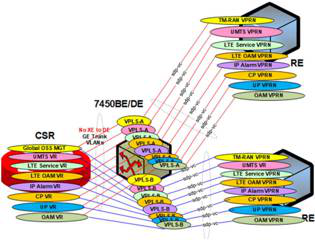


 Document 3
Content:
When there isn't any Converged Edge or Collapse Metro network access coverage in service location, offnet access circuit with dedicated bandwidth can be ordered from a third party carrier. UMTS/HSPA/4G traffic will be transited across third party carrier network and handover to TELUS through NNI network elements. Under offnet scenario of Converged Edge network, HSPA/UMTS/4G access service is be terminated on an edged DE (ESS6) network element. A unique regional VPRN service instance for UMTS/HSPA/4G is to be created across regional edged RE and MSO REs to allow MPLS VPN connections to reach RNCs of regional MSO. For 4G service, they are to be on another VPRN instances.
*As from Q3 - 2019, under TM-RAN OSS architecture, CSR MGT loopback assigns a specific RT '852:5946' at edge RE/SE.
UMTS/HSPA service configuration requirement on a CSR:
-UMTS/HSPA configuration under global routing layer, to be moved to its own VR under new build or CSR HW upgrade as from Q3-2019
-

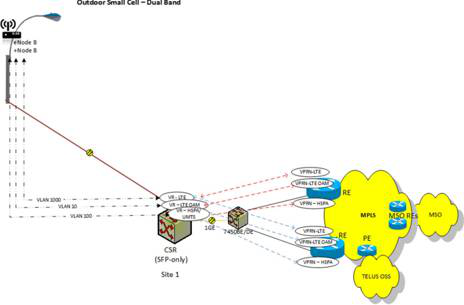

In [ ]:
import base64
from io import BytesIO
from PIL import Image

query = "Give me the 'under UMTS/LTE combined Legacy' scenario"
results = vector_db.as_retriever().invoke(query)

for i, document in enumerate(results):
    print(f"\n Document {i + 1}")
    print(f"Content:\n{document.page_content}")
    #print(f"Metadata: {document.metadata}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            print("Displaying embedded image...")
            display(image)  # Use image.show() if you're not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No embedded image found in metadata.")

    print("=" * 80)


INFO:elastic_transport.transport:POST https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220/telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1/_search [status:200 duration:0.012s]



Document 1
Content:
{
  "images": [
    {
      "image_id": "",
      "title": "CSR VR (VRF) instances design",
      "type": "diagram",
      "page_reference": "",
      "revision_or_version": "",
      "author_or_source": "",
      "creation_or_issue_date": "",
      "description": "CSR VR (VRF) instances design",
      "diagram_elements": [
        {
          "element_name": "CSR",
          "element_type": "router",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": [],
            "other_details": ""
          }
        }
      ],
      "connections_or_relationships": [],
      "purpose_or_scenario": "CSR VR (VRF) instances design",
      "associated_vr_or_network_context": [],
      "relevant_configuration_details": [],
      "notes_and_annotations": ""
    }
  ]
}
Displaying embedded image...


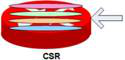


Document 2
Content:
{
  "images": [
    {
      "image_id": "",
      "title": "CSR VRs logical separation",
      "type": "diagram",
      "page_reference": "",
      "revision_or_version": "",
      "author_or_source": "",
      "creation_or_issue_date": "",
      "description": "Illustration of CSR VRs logical separation",
      "diagram_elements": [
        {
          "element_name": "Red Ellipse",
          "element_type": "graphic",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": [],
            "other_details": ""
          }
        },
        {
          "element_name": "Horizontal Lines",
          "element_type": "graphic",
          "properties": {
            "dimensions": "",
            "power_specs": "",
            "ports_or_interfaces": [],
            "ip_addresses": [],
        

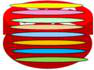


Document 3
Content:
Under current LTE IP RAN service design, CSR is to create multiple VRFs to separate management, and user traffic functionality. A typical CSR setup will be a HUB and Spoke, standalone design, and with certain IP space requirements as shown.
No embedded image found in metadata.

Document 4
Content:
{
  "images": [
    {
      "image_id": "LAN Connectivity Scenario#2 - CSR to User/Control Plane e/g Node B",
      "title": "LTE Service VR",
      "type": "Network Diagram",
      "page_reference": "None",
      "revision_or_version": "None",
      "author_or_source": "None",
      "creation_or_issue_date": "None",
      "description": "A network diagram showing the connectivity between a CSR and an eNodeB in a LAN scenario.",
      "diagram_elements": [
        {
          "element_name": "CSR",
          "element_type": "Router",
          "properties": {
            "dimensions": "None",
            "power_specs": "None",
            "ports_or_interfaces": ["GE/XE Tr

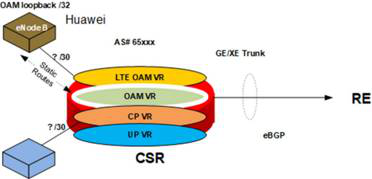

In [17]:
query = "CSR VR (VRF) instances design diagram"
i = 0

results = vector_db.as_retriever().invoke(query)

for i, document in enumerate(results):
    print(f"\nDocument {i + 1}")
    print(f"Content:\n{document.page_content}")
    #print(f"Metadata: {document.metadata}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            print("Displaying embedded image...")
            display(image)  # Use image.show() if you're not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No embedded image found in metadata.")

    print("=" * 80)


The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

`{context}` will hold the retrieved chunks, as shown in the previous search, and feeds this to the model as document context for answering our question.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!

INFO:elastic_transport.transport:POST https://abaf66f0-1ef1-40ce-a820-5acccb045df4.d7deeff0d58745aba57fa5c84685d5b4.databases.appdomain.cloud:32220/telus-index-csr-acx7024-configuration-guide-v1.1-mxbai-embed-large-v1/_search [status:200 duration:0.013s]



📄 Document 1
📝 Content:
{
  "images": [
    {
      "image_id": "Deployment : Physical Connection",
      "title": "Juniper ACX7024",
      "type": "Deployment Diagram",
      "page_reference": "Section n/a",
      "revision_or_version": "Not specified",
      "author_or_source": "Not specified",
      "creation_or_issue_date": "Not specified",
      "description": "Juniper ACX7024 with multirate ports and optical transceivers.",
      "diagram_elements": [
        {
          "element_name": "Juniper ACX7024",
          "element_type": "Router",
          "properties": {
            "dimensions": "Not specified",
            "power_specs": "Not specified",
            "ports_or_interfaces": [
              "1G/10G/25G",
              "40G/100G",
              "DWDM",
              "CWDM"
            ],
            "ip_addresses": [],
            "protocols": [],
            "vlan_tags": [],
            "roles": [],
            "other_details": "Multirate ports, tunable DWDM and CWDM 

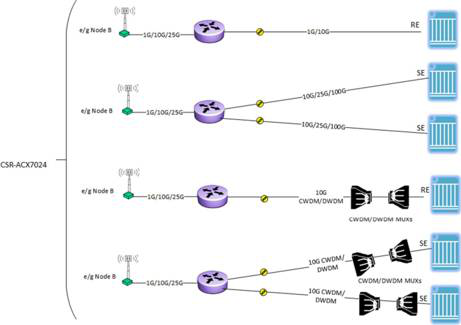


📄 Document 2
📝 Content:
https://www.juniper.net/documentation/us/en/hardware/acx7024/topics/task/acx7024-installing-andconnecting.html
No embedded image found in metadata.

📄 Document 3
📝 Content:
{
  "images": [
    {
      "image_id": "Scenario 2 - Geo Redundant PIOT Sites Connection",
      "title": "Geo Redundant PIOT Sites Connection",
      "type": "Network Diagram",
      "page_reference": "Deployment Scenario",
      "revision_or_version": "N/A",
      "author_or_source": "N/A",
      "creation_or_issue_date": "N/A",
      "description": "Geo Redundant PIOT Sites Connection Diagram",
      "diagram_elements": [
        {
          "element_name": "CSR",
          "element_type": "Router",
          "properties": {
            "dimensions": "N/A",
            "power_specs": "N/A",
            "ports_or_interfaces": ["GigabitEthernet0/0/0", "GigabitEthernet0/0/1"],
            "ip_addresses": ["10.10.10.1", "10.10.10.2"],
            "protocols": ["OSPF"],
            "vlan_tags

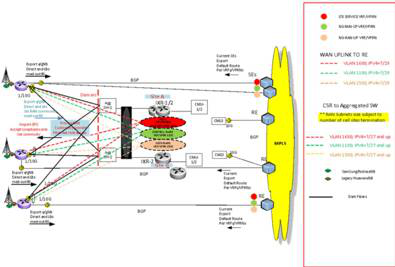


📄 Document 4
📝 Content:
{
  "images": [
    {
      "image_id": "Indoor Small Cell Deployment",
      "title": "Indoor Small Cell Deployment",
      "type": "Network Diagram",
      "page_reference": "Not provided",
      "revision_or_version": "Not provided",
      "author_or_source": "Not provided",
      "creation_or_issue_date": "Not provided",
      "description": "Indoor Small Cell Deployment",
      "diagram_elements": [
        {
          "element_name": "SC-INET VR",
          "element_type": "Virtual Router",
          "properties": {
            "dimensions": "Not provided",
            "power_specs": "Not provided",
            "ports_or_interfaces": [
              "GE (Gigabit Ethernet)",
              "7/29 or more Public Routable IP"
            ],
            "ip_addresses": "Not provided",
            "protocols": "Not provided",
            "vlan_tags": "Not provided",
            "roles": [
              "CSR Hub (CO location)"
            ],
            "other_de

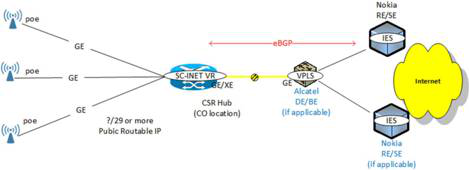

In [18]:
query = "Deployment : Physical Connection"
i = 0

results = vector_db.as_retriever().invoke(query)

for i, document in enumerate(results):
    print(f"\n📄 Document {i + 1}")
    print(f"📝 Content:\n{document.page_content}")
    #print(f"📁 Metadata: {document.metadata}")

    image_base64 = document.metadata.get("image_base64")

    if image_base64:
        try:
            image_data = base64.b64decode(image_base64)
            image = Image.open(BytesIO(image_data))
            print("Displaying embedded image...")
            display(image)  # Use image.show() if you're not in a notebook
        except Exception as e:
            print("Failed to decode/display image:", e)
    else:
        print("No embedded image found in metadata.")

    print("=" * 80)